In [1]:
import numpy as np 
from matplotlib import pyplot as plt 
import seaborn as sns 
from tqdm import tqdm 
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier  , AdaBoostClassifier , GradientBoostingClassifier
from sklearn.metrics import precision_score , recall_score 
import xgboost as xgb 
import pandas as pd 
import sklearn.neighbors._base
from os import sys
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from missingpy import MissForest 
from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay
sns.set_style('whitegrid')
%load_ext autoreload
%autoreload 2
sns.set_style('whitegrid')
from IPython.display import display

In [2]:
def details(data_sent , comments = ''):
    if(comments):
        print(comments)
    sp = (data_sent.isna().sum().sum())/ data_sent.size
    print('________________________________________________')
    print('Sparsity in the data : {:.2f}'.format(sp))
    num_rows = data_sent.shape
    print('Data shape' , num_rows)
    #display(data_sent['class'].value_counts())
    print('Number of sources : ')
    cl = data_sent['class'].unique()
    for c in cl:
        num_src = len(data_sent[data_sent['class']==c]['src_id'].unique())
        num_obs = len(data_sent[data_sent['class']==c])
        print(c ,' \t ' , num_src , '\t' , num_obs)

In [3]:
from features import phot_flux , en_flux , hard, powlaw_fit , bb_fit , brems_fit , intra_obs_var , inter_ob_var , info_col , phot_flux_hilim , phot_flux_lolim , en_flux_hilim , en_flux_lolim

In [4]:
info_col_cl =  info_col+['class']

In [5]:
data_imp_v2 = pd.read_csv('imputed_data/new-data-all-at-once-imp.csv' , index_col='obs_id')

In [6]:
details(data_imp_v2)

________________________________________________
Sparsity in the data : 0.00
Data shape (3103, 59)
Number of sources : 
CV  	  184 	 1582
PL  	  178 	 1000
LX  	  58 	 521


In [7]:

df_comb = pd.DataFrame()
for s in data_imp_v2['src_id'].unique()[:]:
    temp = data_imp_v2[data_imp_v2['src_id']==s]
    temp_id =  temp[info_col_cl]
    temp_val = temp.drop(columns=info_col_cl)
    temp_mean = temp_val.mean().to_frame().T
    temp_id_top = temp_id.iloc[0:1].reset_index()
    temp_final = pd.concat([temp_id_top , temp_mean] , axis=1).set_index('obs_id')
    df_comb = df_comb.append(temp_final)
display(df_comb)


,src_id,num_obs,src_n,name,ra,dec,livetime,significance,likelihood,class,...,kp_prob_b,var_max_b,var_min_b,var_mean_b,var_sigma_b,ks_prob_b,var_prob_b,var_inter_index_s,var_inter_index_m,var_inter_sigma_u
obs_id,,,,,,,,,,,,,,,,,,,,,
CV_0_obs_0,CV_0,25,CSS120424:125906+242634,2CXO J004247.1+411619,10.696540,41.272150,4103.7,52.93,16618.73000,CV,...,0.600161,0.007931,0.002263,0.002978,0.001218,0.515405,0.523568,5.00,3.07375,5.417707e-04
CV_1_obs_0,CV_1,12,W32,2CXO J002405.6-720449,6.023632,-72.080360,31673.8,20.78,1834.51100,CV,...,0.636945,0.004085,0.001735,0.002451,0.000613,0.614881,0.574516,5.00,3.00000,9.789000e-07
CV_2_obs_0,CV_2,8,CXOGlb_J002405.2-720446,2CXO J002405.2-720446,6.021793,-72.079680,5544.8,9.72,548.75650,CV,...,0.677229,0.004417,0.001721,0.002179,0.000574,0.665955,0.543535,3.00,4.00000,1.081000e-06
CV_3_obs_0,CV_3,13,Cl__NGC_104_MAM_M54898,2CXO J002406.0-720456,6.025117,-72.082280,65237.5,25.99,3275.90600,CV,...,0.353444,0.004808,0.003408,0.003737,0.000345,0.381742,0.226397,6.00,8.00000,7.858000e-07
CV_4_obs_0,CV_4,13,CXOGlb_J002404.9-720455,2CXO J002404.9-720455,6.020589,-72.082100,31673.8,19.64,2291.21000,CV,...,0.746582,0.005740,0.002950,0.003574,0.000689,0.606845,0.558287,3.00,4.00000,1.098000e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LMXB_86_obs_0,LMXB_86,1,SAX_J1810.8-2609_____,2CXO J181044.4-260901,272.685300,-26.150370,31871.5,9.29,512.97550,LX,...,0.539000,0.003494,0.003420,0.003456,0.000029,0.829000,0.084000,5.11,3.03000,2.125299e-05
LMXB_90_obs_0,LMXB_90,1,XTE_J2123-058________,2CXO J212314.5-054753,320.810600,-5.798128,17705.1,4.06,132.76700,LX,...,0.211000,0.003517,0.001060,0.001171,0.000255,0.265000,0.807000,5.00,3.03000,2.151511e-05
LMXB_91_obs_0,LMXB_91,1,XB_1732-304__________,2CXO J173547.0-302858,263.945900,-30.482820,18855.8,4.89,114.24570,LX,...,0.547000,0.002756,0.001488,0.001623,0.000211,0.735000,0.451000,3.00,5.00000,8.482809e-07


In [8]:
data_id = df_comb[info_col]
data_label = df_comb['class']
data_val = df_comb.drop(columns=['class']+info_col)
data_imp_norm = df_comb.copy()
for c in data_val.columns.to_list():
    data_imp_norm.loc[:,c] = (data_imp_norm.loc[:,c] - data_imp_norm.loc[:,c].mean()) / data_imp_norm.loc[:,c].std()
data_imp_norm

,src_id,num_obs,src_n,name,ra,dec,livetime,significance,likelihood,class,...,kp_prob_b,var_max_b,var_min_b,var_mean_b,var_sigma_b,ks_prob_b,var_prob_b,var_inter_index_s,var_inter_index_m,var_inter_sigma_u
obs_id,,,,,,,,,,,,,,,,,,,,,
CV_0_obs_0,CV_0,25,CSS120424:125906+242634,2CXO J004247.1+411619,10.696540,41.272150,4103.7,52.93,16618.73000,CV,...,0.140383,-0.193753,-0.407606,-0.409996,0.042725,-0.250447,0.492569,0.200236,-0.756434,0.168818
CV_1_obs_0,CV_1,12,W32,2CXO J002405.6-720449,6.023632,-72.080360,31673.8,20.78,1834.51100,CV,...,0.300193,-0.422380,-0.452348,-0.450546,-0.153447,0.182504,0.710415,0.200236,-0.795530,-0.096487
CV_2_obs_0,CV_2,8,CXOGlb_J002405.2-720446,2CXO J002405.2-720446,6.021793,-72.079680,5544.8,9.72,548.75650,CV,...,0.475208,-0.402661,-0.453504,-0.471439,-0.166164,0.404797,0.577944,-0.948770,-0.265416,-0.096436
CV_3_obs_0,CV_3,13,Cl__NGC_104_MAM_M54898,2CXO J002406.0-720456,6.025117,-72.082280,65237.5,25.99,3275.90600,CV,...,-0.931496,-0.379399,-0.310762,-0.351673,-0.240642,-0.832196,-0.778104,0.774739,1.855039,-0.096581
CV_4_obs_0,CV_4,13,CXOGlb_J002404.9-720455,2CXO J002404.9-720455,6.020589,-72.082100,31673.8,19.64,2291.21000,CV,...,0.776519,-0.324030,-0.349557,-0.364175,-0.128738,0.147528,0.641022,-0.948770,-0.265416,-0.096428
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LMXB_86_obs_0,LMXB_86,1,SAX_J1810.8-2609_____,2CXO J181044.4-260901,272.685300,-26.150370,31871.5,9.29,512.97550,LX,...,-0.125336,-0.457551,-0.309760,-0.373279,-0.343210,1.114425,-1.386978,0.263431,-0.779626,-0.086540
LMXB_90_obs_0,LMXB_90,1,XTE_J2123-058________,2CXO J212314.5-054753,320.810600,-5.798128,17705.1,4.06,132.76700,LX,...,-1.550353,-0.456183,-0.509419,-0.548922,-0.269642,-1.340299,1.704492,0.200236,-0.779626,-0.086412
LMXB_91_obs_0,LMXB_91,1,XB_1732-304__________,2CXO J173547.0-302858,263.945900,-30.482820,18855.8,4.89,114.24570,LX,...,-0.090579,-0.501432,-0.473210,-0.514178,-0.283957,0.705305,0.182274,-0.948770,0.264698,-0.096551


In [9]:
details(data_imp_norm)

________________________________________________
Sparsity in the data : 0.00
Data shape (420, 59)
Number of sources : 
CV  	  184 	 184
PL  	  178 	 178
LX  	  58 	 58


In [88]:
verbose = 0
val_acc = []
test_acc = []
rs = 999
for i in tqdm(range(1)):
    rs = int(np.random.randint(0,99999))
    rs = 13186
    np.random.seed(rs)
    src_list = pd.DataFrame()
    class_to_select = ['CV' , 'LX' , 'PL']
    df = data_imp_norm.copy()
    i_val = df[info_col]
    y_val = df['class']
    x_val = df.drop(columns=['class']+info_col)
    x_train , x_test ,i_train, i_test ,  y_train , y_test = train_test_split(x_val , i_val ,y_val , test_size=0.3 , stratify=y_val, random_state=42)
    clf = RandomForestClassifier(n_estimators=200 , )
    clf.fit(x_train , y_train ,sample_weight=i_train['significance'])
    v_sc = clf.score(x_test , y_test)
    test_sc = clf.score(x_train, y_train)
    val_acc.append(v_sc)
    test_acc.append(test_sc)
    #if(verbose):
    print(rs ,  v_sc)

100%|██████████| 1/1 [00:00<00:00,  1.57it/s]

13186 0.7936507936507936


In [89]:
score = pd.DataFrame({
    "Test Score" : test_acc, 
    "Validation Score" : val_acc
})*100
score.describe().loc[['mean' , 'std' , 'min', 'max' ]]

,Test Score,Validation Score
mean,98.979592,79.365079
std,NaN,NaN
min,98.979592,79.365079
max,98.979592,79.365079


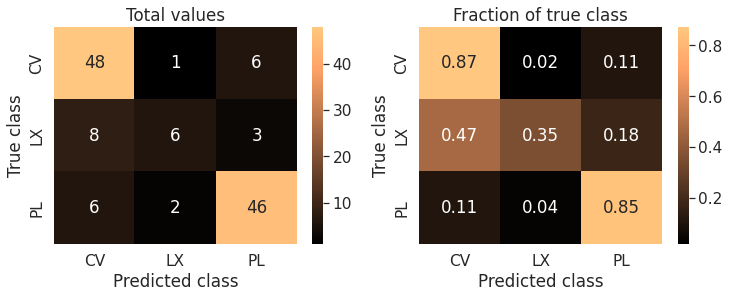

In [91]:
sns.set(font_scale=1.4)
sns.set_style('whitegrid')
fig , ax = plt.subplots(nrows=1 , ncols= 2 , figsize = (12 , 4))
cf = confusion_matrix(y_test , clf.predict(x_test) ,)
sns.heatmap(cf , annot=True ,fmt = '.0f' , ax = ax[0] , xticklabels=class_to_select, yticklabels = class_to_select , cmap='copper')
cf = confusion_matrix(y_test , clf.predict(x_test) ,normalize='true')
sns.heatmap(cf , annot=True ,fmt = '.2f' , ax = ax[1] , xticklabels=class_to_select, yticklabels = class_to_select , cmap='copper')
ax[0].set_title('Total values')
ax[1].set_title('Fraction of true class')
for a in ax:
    a.set_xlabel('Predicted class')
    a.set_ylabel('True class')
plt.show()
#score

In [92]:
y_pred_prob = [np.amax(pi) for pi in clf.predict_proba(x_train)]
y_pred_class = clf.predict(x_train)
y_pred_prob = pd.DataFrame({'pred_class': y_pred_class , 'pred_prob' :y_pred_prob})
#y_pred_prob  = y_pred_prob.melt().rename({'variable' : 'class' , 'value' : 'pred_prob'} , axis=1)
y_pred_prob

,pred_class,pred_prob
0,PL,0.687500
1,CV,0.775000
2,CV,0.800000
3,PL,0.760000
4,PL,0.907917
...,...,...
289,LX,0.945000
290,LX,0.746667
291,LX,0.670000
292,CV,0.822500


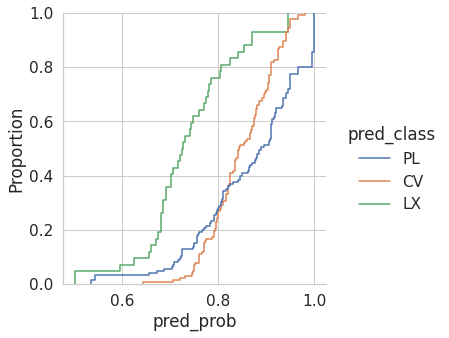

In [93]:
sns.displot(
    data = y_pred_prob , 
    x = 'pred_prob' , 
    hue = 'pred_class' , 
    kind='ecdf'
)
plt.show()

In [41]:
from sklearn.metrics import precision_score , recall_score

In [43]:
y_pred = clf.predict(x_test)
ps = precision_score(y_test , y_pred , average = None) 
rc = recall_score(y_test , y_pred , average = None)
sc = pd.DataFrame({
    'precision' : ps , 
    'recall' : rc , 
    } ,  index=['CV' , 'LMXB' , 'PULSAR'])
sc 

,precision,recall
CV,0.774194,0.872727
LMXB,0.666667,0.352941
PULSAR,0.836364,0.851852


# SMOTE

In [44]:
from imblearn.over_sampling import SMOTE

In [66]:
verbose = 0
val_acc = []
test_acc = []
rs = 999
for i in tqdm(range(1)):
    rs = int(np.random.randint(0,99999))
    rs = 39440
    np.random.seed(rs)
    src_list = pd.DataFrame()
    class_to_select = ['CV' , 'LX' , 'PL']
    df = data_imp_norm.copy()
    i_val = df[info_col]
    y_val = df['class']
    x_val = df.drop(columns=['class']+info_col)
    x_train , x_test ,i_train, i_test ,  y_train , y_test = train_test_split(x_val , i_val ,y_val , test_size=0.3 , stratify=y_val, random_state=42)
    clf = RandomForestClassifier(n_estimators=200 , )

    oversample = SMOTE(k_neighbors=10 , n_jobs=-1)
    x_train , y_train = oversample.fit_resample(x_train , y_train)

    clf.fit(x_train , y_train)
    v_sc = clf.score(x_test , y_test)
    test_sc = clf.score(x_train, y_train)
    val_acc.append(v_sc)
    test_acc.append(test_sc)
    #if(verbose):
    print(rs ,  v_sc)

100%|██████████| 1/1 [00:00<00:00,  1.40it/s]

39440 0.7857142857142857


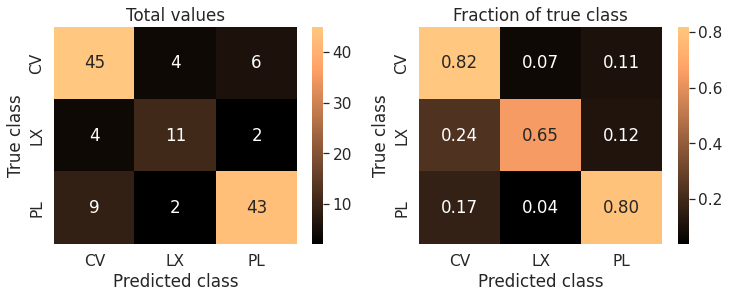

In [67]:
sns.set(font_scale=1.4)
sns.set_style('whitegrid')
fig , ax = plt.subplots(nrows=1 , ncols= 2 , figsize = (12 , 4))
cf = confusion_matrix(y_test , clf.predict(x_test) ,)
sns.heatmap(cf , annot=True ,fmt = '.0f' , ax = ax[0] , xticklabels=class_to_select, yticklabels = class_to_select , cmap='copper')
cf = confusion_matrix(y_test , clf.predict(x_test) ,normalize='true')
sns.heatmap(cf , annot=True ,fmt = '.2f' , ax = ax[1] , xticklabels=class_to_select, yticklabels = class_to_select , cmap='copper' )
ax[0].set_title('Total values')
ax[1].set_title('Fraction of true class')
for a in ax:
    a.set_xlabel('Predicted class')
    a.set_ylabel('True class')
plt.show()
#score

In [69]:
y_pred = clf.predict(x_test)
ps = precision_score(y_test , y_pred , average = None) 
rc = recall_score(y_test , y_pred , average = None)
sc = pd.DataFrame({
    'precision' : ps , 
    'recall' : rc , 
    } ,  index=['CV' , 'LMXB' , 'PULSAR'])
sc 

,precision,recall
CV,0.775862,0.818182
LMXB,0.647059,0.647059
PULSAR,0.843137,0.796296


## ECDF plot

In [86]:
y_pred_prob = [np.amax(pi) for pi in clf.predict_proba(x_train)]
y_pred_class = clf.predict(x_train)
y_pred_prob = pd.DataFrame({'pred_class': y_pred_class , 'pred_prob' :y_pred_prob})
#y_pred_prob  = y_pred_prob.melt().rename({'variable' : 'class' , 'value' : 'pred_prob'} , axis=1)
y_pred_prob

,pred_class,pred_prob
0,PL,0.680000
1,CV,0.782500
2,CV,0.770000
3,PL,0.815000
4,PL,0.863333
...,...,...
382,PL,0.912500
383,PL,0.950000
384,PL,0.810000
385,PL,0.941667


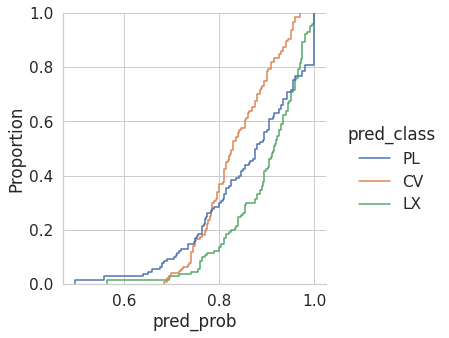

In [87]:
sns.displot(
    data = y_pred_prob , 
    x = 'pred_prob' , 
    hue = 'pred_class' , 
    kind='ecdf'
)
plt.show()

# Hyper Parameter Tuning

In [105]:
def calculate_score(clf , df):
    verbose = 0
    val_acc = []
    test_acc = []
    rs = 999
    for i in (range(16)):
        rs = int(np.random.randint(0,99999))
        #rs = 13186
        np.random.seed(rs)
        src_list = pd.DataFrame()
        class_to_select = ['CV' , 'LX' , 'PL']
        #df = data_imp_norm.copy()
        i_val = df[info_col]
        y_val = df['class']
        x_val = df.drop(columns=['class']+info_col)
        x_train , x_test ,i_train, i_test ,  y_train , y_test = train_test_split(x_val , i_val ,y_val , test_size=0.3 , stratify=y_val, random_state=42)
        
        clf.fit(x_train , y_train ,sample_weight=i_train['significance'])
        v_sc = clf.score(x_test , y_test)
        test_sc = clf.score(x_train, y_train)
        val_acc.append(v_sc)
        test_acc.append(test_sc)
        #if(verbose):
        #print(rs ,  v_sc)
    return val_acc


In [100]:

res = calculate_score(clf , data_imp_norm)


100%|██████████| 16/16 [00:10<00:00,  1.59it/s]

0.767361111111111 0.014230147110893895


In [124]:
num_trees = [10 , 30 , 50 , 100 , 200 , 300 , 400 , 500 , 600 , 700 , 800]
tree_score = pd.DataFrame()
for n in tqdm(num_trees):
    clf = RandomForestClassifier(n_estimators = n)
    res = calculate_score(clf , data_imp_norm)
    temp = pd.DataFrame({'num_trees' : [n]*len(res) , 'Val_accuracy' : res})
    tree_score =  tree_score.append(temp)
tree_score

100%|██████████| 11/11 [02:54<00:00, 15.88s/it]


,num_trees,Val_accuracy
0,10,0.666667
1,10,0.619048
2,10,0.730159
3,10,0.746032
4,10,0.730159
...,...,...
11,800,0.785714
12,800,0.777778
13,800,0.777778
14,800,0.793651


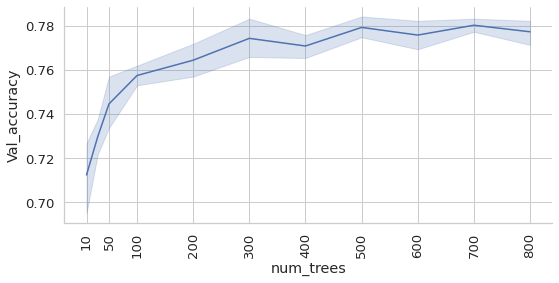

In [133]:
num_trees_small = [10 , 50 , 100 , 200 , 300 , 400 , 500 , 600 , 700 , 800]
sns.set(font_scale=1.2 , style='whitegrid')
#sns.set_theme
g = sns.relplot(
    data = tree_score.reset_index(drop=True) , 
    kind= 'line' ,
    y= 'Val_accuracy',
    x = 'num_trees' , 
    height= 4 ,
    aspect= 8/4 , 
)
#g.set_xticks = num_trees
g.ax.set_xticks(num_trees_small)
g.ax.set_xticklabels(num_trees_small, rotation=90)
plt.show()

In [135]:
num_trees = [10 , 30 , 50 , 100 , 200 , 300 , 400 , 500 , 600 , 700 , 800]
max_depth = np.arange(1,15 , step=1)
depth_score = pd.DataFrame()
for n in tqdm(max_depth):
    clf = RandomForestClassifier(n_estimators = 500 , max_depth=n)
    res = calculate_score(clf , data_imp_norm)
    temp = pd.DataFrame({'Max_depth' : [n]*len(res) , 'Val_accuracy' : res})
    depth_score =  depth_score.append(temp)
depth_score

100%|██████████| 14/14 [04:44<00:00, 20.29s/it]


,Max_depth,Val_accuracy
0,1,0.444444
1,1,0.492063
2,1,0.452381
3,1,0.476190
4,1,0.428571
...,...,...
11,14,0.769841
12,14,0.801587
13,14,0.793651
14,14,0.777778


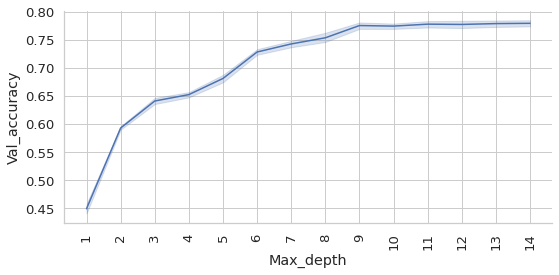

In [138]:

sns.set(font_scale=1.2 , style='whitegrid')
#sns.set_theme
g = sns.relplot(
    data = depth_score.reset_index(drop=True) , 
    kind= 'line' ,
    y= 'Val_accuracy',
    x = 'Max_depth' , 
    height= 4 ,
    aspect= 8/4 , 
)
#g.set_xticks = num_trees
g.ax.set_xticks(max_depth)
g.ax.set_xticklabels(max_depth, rotation=90)
plt.show()